<a href="https://colab.research.google.com/github/robertocsa/Natural-Language-Processing-NLP-/blob/main/PLN5_Tutorial_Agrupamento_Texto_com_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tutorial 1 sobre agrupamento de textos com K-Means**

Base de informações:
Clustering with Bert Embeddings
(https://www.youtube.com/watch?v=Kc9gN_gODvQ)

Neste experimento, a base de Súmulas jurisprudenciais disponibilizada no portal do Supremo Tribunal Federal (STF) será utilizada.

Link utilizado para download do arquivo .CSV contendo o repositório de súmulas do STF:
https://jurisprudencia.stf.jus.br/pages/search?base=sumulas&pesquisa_inteiro_teor=false&sinonimo=true&plural=true&radicais=false&buscaExata=true&page=1&pageSize=10&queryString=sumulas&sort=_score&sortBy=desc

A experiência consiste em agrupar as súmulas por temas, de modo não supervisionado, utilizando o algoritmo de K-Means.

Na versão atual, agrupamos as súmulas do STF em **3 grandes grupos** (*clusterização* com K-Means e K=3), não necessariamente nesta ordem:

**Grupo 0** - Súmulas de Direito Tributário (inclui matéria Previdenciária)

**Grupo 1** - Súmulas de Direito Penal

**Grupo 2** - Demais súmulas (Mandado de Segurança, Servidores Públicos etc).


**Carregando os pacotes (loading packages)**


In [ ]:
import os
import pandas as pd
!pip install sentence_transformers
!pip install preprocessor
# Documentação: https://www.sbert.net/
from sentence_transformers import SentenceTransformer
# Utilizamos o transformer derivado do algoritmo BERT visto abaixo
embedder = SentenceTransformer('distilbert-base-nli-mean-tokens')
#embedder = SentenceTransformer('all-MiniLM-L6-v2')

import re
import preprocessor as p

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Documentação do Sentence Transformer:**

https://www.sbert.net/

In [ ]:
type(embedder)

sentence_transformers.SentenceTransformer.SentenceTransformer

**Lendo os dados**

***Reading data***

In [ ]:
import os
import pandas as pd
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/Apres Prog Ling Natural PLN/input/')
df=pd.read_csv('SumulasSTF.csv',header='infer', sep=";", on_bad_lines='skip')
df.head(6)
df

,Titulo,Data de aprovação,Enunciado
0,Súmula vinculante 38,11/03/2015,É competente o Município para fixar o horário de funcionamento de estabelecimento comercial.
1,Súmula vinculante 40,11/03/2015,"A contribuição confederativa de que trata o art. 8º, IV, da Constituição Federal, só é exigível dos filiados ao sindicato respectivo."
2,Súmula vinculante 39,11/03/2015,Compete privativamente à União legislar sobre vencimentos dos membros das polícias civil e militar e do corpo de bombeiros militar do Distrito Fed...
3,Súmula vinculante 41,11/03/2015,O serviço de iluminação pública não pode ser remunerado mediante taxa.
4,Súmula vinculante 42,11/03/2015,É inconstitucional a vinculação do reajuste de vencimentos de servidores estaduais ou municipais a índices federais de correção monetária.
...,...,...,...
782,Súmula 88,13/12/1963,"É válida a majoração da tarifa alfandegária, resultante da L. 3.244, de 14.8.57, que modificou o Acordo Geral sobre Tarifas Aduaneiras e Comércio ..."
783,Súmula 219,13/12/1963,"Para a indenização devida a empregado que tinha direito a ser readmitido, e não foi, levam-se em conta as vantagens advindas à sua categoria no pe..."
784,Súmula 320,13/12/1963,"A apelação despachada pelo juiz no prazo legal não fica prejudicada pela demora da juntada, por culpa do cartório."
785,Súmula 356,13/12/1963,"O ponto omisso da decisão, sobre o qual não foram opostos embargos declaratórios, não pode ser objeto de recurso extraordinário, por faltar o requ..."


In [ ]:
df.info()
df.isnull().any()
df.isna().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787 entries, 0 to 786
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Titulo             787 non-null    object
 1   Data de aprovação  787 non-null    object
 2   Enunciado          787 non-null    object
dtypes: object(3)
memory usage: 18.6+ KB


Titulo               False
Data de aprovação    False
Enunciado            False
dtype: bool

**Observação quanto à vigência das súmulas**

Nos primeiros experimentos que fiz, utilizei a base (os dados do dataset de súmulas) completa, sem levar em consideração a data de publicação, pois a maioria das súmulas foi publicada antes da vigência da Constituição Federal atual (Vigente a partir de outubro de 1988). Como se trata apenas de experiência para fins didáticos, a permanência de uma quantidade maior de súmulas é interessante sob o ponto de vista do estudo de Programação de Linguagem Natural (PLN).

Depois que visualizei os resultados iniciais do modelo elaborado conforme dito acima, decidi utilizar, agora, em uma revisão deste experimento, somente a base de dados de súmulas publicadas após a vigência da Constituição atual, ou seja, após outubro de 1988. Isso simplifica a complexidade do modelo. E continua interessante, permitindo inclusive melhor visualização dos dados.

In [ ]:
import pandas as pd
from datetime import datetime
#corpus=list(df['Enunciado'])   # Para visualizar a base completa, incluindo-se as súmulas publicadas antes de 1988, comente as linhas de baixo e "descomente" esta

# FILTRO de DATA (Filtra as datas de acordo com a vigência da atual Constituição Federal - CF)
# Para usar toda a base, sem esse filtro, basta comentar todas estas linhas e utilizar apenas a linha acima (descomente-a)
dataPublicacaoCF=datetime.strptime("05/10/1988",'%d/%m/%Y')
datasDeAprovacao=[datetime.strptime(x,'%d/%m/%Y') for x in df['Data de aprovação']]
condicao = [x >= dataPublicacaoCF for x in datasDeAprovacao]
df['condicao']=condicao  # Acrescenta no dataframe uma coluna booleana (true para datas posteriores à vigência da CF)
corpus['Enunciado']=df[(df['condicao']==True)]['Enunciado']
print(type(corpus))
#corpus=corpus.to_frame()
#corpus.set_option('display.max_colwidth', None)
pd.options.display.max_colwidth = 150  # set a value as your need
pd.options.display.max_rows = 170  # set a value as your need
print(corpus)

<class 'pandas.core.frame.DataFrame'>
                                                                                                                                                       Enunciado
0                                                                   É competente o Município para fixar o horário de funcionamento de estabelecimento comercial.
1                          A contribuição confederativa de que trata o art. 8º, IV, da Constituição Federal, só é exigível dos filiados ao sindicato respectivo.
2          Compete privativamente à União legislar sobre vencimentos dos membros das polícias civil e militar e do corpo de bombeiros militar do Distrito Fed...
3                                                                                         O serviço de iluminação pública não pode ser remunerado mediante taxa.
4                     É inconstitucional a vinculação do reajuste de vencimentos de servidores estaduais ou municipais a índices federais de correção monetár

**Limpeza de Stop-Words e de pontuação**


In [ ]:
import string
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('portuguese')
pontuacao=string.punctuation
#pontuacao=pontuacao.replace("-","")
pontuacao=pontuacao.replace("/","")
listaPalavrasComuns=list(['xxxvi','passivo','adct','cinco','nula','viola','constitui','constitucional','inconstitucional',
                          'artigo','viii','xiii','inciso','sob','prazo','recurso','extraordinário','desde','d','l','nº',
                          'cabe', 'decisão', 'justiça', 'lei', 'direito', 'ainda', 'pode', 'sobre', 'constituição',
                          'federal', 'supremo', 'tribunal', 'contra','respectivo', 'poder', 'judiciário','trata',
                          'art','arts','art.s','vi','c'])
listaExclWords=stopwords+listaPalavrasComuns
corpus2=[]
print(type(corpus))
for i, enunciado in enumerate(corpus['Enunciado']):
  if (i==171): break
  #translateTable=a_string.maketrans('', '', pontuacao)
  #new_string = a_string.translate(translateTable)
  #Tokenização de palavras:
  if (not pd.isna(enunciado) and len(enunciado)>2):
    tokens = nltk.word_tokenize(enunciado)
  #print(i,a_string)
  #tokens=a_string.split()
  #display(listaExclWords)
  # Filtrando as stop words
  fd = [w.lower() for w in tokens if w.lower() not in listaExclWords]
  fd=' '.join(fd)
  corpus2.append(fd)

  #if (i>120 and i<141):
  print("Sentença %2d %s" % (i, corpus2[i]))


<class 'pandas.core.frame.DataFrame'>
Sentença  0 competente município fixar horário funcionamento estabelecimento comercial .
Sentença  1 contribuição confederativa . 8º , iv , , exigível filiados sindicato .
Sentença  2 compete privativamente união legislar vencimentos membros polícias civil militar corpo bombeiros militar distrito .
Sentença  3 serviço iluminação pública remunerado mediante taxa .
Sentença  4 vinculação reajuste vencimentos servidores estaduais municipais índices federais correção monetária .
Sentença  5 medida provisória apreciada congresso nacional podia , emenda 32/2001 , reeditada dentro eficácia trinta dias , mantidos efeitos primeira edição .
Sentença  6 auxílio-alimentação estende servidores inativos .
Sentença  7 , função legislativa , aumentar vencimentos servidores públicos fundamento isonomia .
Sentença  8 alugado terceiros , permanece imune iptu imóvel pertencente qualquer entidades referidas . 150 , , , , valor aluguéis aplicado atividades quais tais en

**Remove os tokens que contêm números ou são muito pequenos e sem interesse como vi**

In [ ]:
# Retorna True se houver algum caractere numérico no token
# Aproveita, remove também tokens que contenham apenas uma letra como 'i' ou duas letras como 'iv' e §
def isNumericToken(token):
  retorno=False
  for char in token:
    if (char in '0123456789º§'):
      retorno=True
      break
  return retorno

# Remove os tokens numéricos contidos em uma determinada sentença (sentença no sentido gramatical)
def removeNumericToken(sentenca):
  retorno=""
  lstTokens=sentenca.split(" ")
  for token in lstTokens:
    #if (not isNumericToken(token) and not len(token)<4):
    if (not len(token)<4):
      retorno=retorno+" "+token
  return retorno

corpus3=[]
## Remove os tokens que contêm números:
for i,sentenca in enumerate(corpus2):
  novaSentenca=removeNumericToken(sentenca)
  novaSentenca=novaSentenca.lstrip()
  if (len(novaSentenca)>4):
    corpus3.append(novaSentenca)
  print(i, novaSentenca)
corpus2=corpus3
#display(corpus2)

0 competente município fixar horário funcionamento estabelecimento comercial
1 contribuição confederativa exigível filiados sindicato
2 compete privativamente união legislar vencimentos membros polícias civil militar corpo bombeiros militar distrito
3 serviço iluminação pública remunerado mediante taxa
4 vinculação reajuste vencimentos servidores estaduais municipais índices federais correção monetária
5 medida provisória apreciada congresso nacional podia emenda 32/2001 reeditada dentro eficácia trinta dias mantidos efeitos primeira edição
6 auxílio-alimentação estende servidores inativos
7 função legislativa aumentar vencimentos servidores públicos fundamento isonomia
8 alugado terceiros permanece imune iptu imóvel pertencente qualquer entidades referidas valor aluguéis aplicado atividades quais tais entidades constituídas
9 ofende princípio livre concorrência municipal impede instalação estabelecimentos comerciais ramo determinada área
10 entrada mercadoria importada exterior legíti

In [ ]:
corpus2=corpus3
corpus2

['competente município fixar horário funcionamento estabelecimento comercial',
 'contribuição confederativa exigível filiados sindicato',
 'compete privativamente união legislar vencimentos membros polícias civil militar corpo bombeiros militar distrito',
 'serviço iluminação pública remunerado mediante taxa',
 'vinculação reajuste vencimentos servidores estaduais municipais índices federais correção monetária',
 'medida provisória apreciada congresso nacional podia emenda 32/2001 reeditada dentro eficácia trinta dias mantidos efeitos primeira edição',
 'auxílio-alimentação estende servidores inativos',
 'função legislativa aumentar vencimentos servidores públicos fundamento isonomia',
 'alugado terceiros permanece imune iptu imóvel pertencente qualquer entidades referidas valor aluguéis aplicado atividades quais tais entidades constituídas',
 'ofende princípio livre concorrência municipal impede instalação estabelecimentos comerciais ramo determinada área',
 'entrada mercadoria import

**Lematização *(lemming)* e Derivação (*stemming*)**

In [ ]:
corpus2=corpus3
corpus2

# Lemming
!python -m spacy download pt
import spacy
nlp = spacy.load('pt_core_news_sm')
#doc = nlp(str([palavra for palavra in df_palavras['Original']]))

# Stemming
import nltk
nltk.download('rslp')
stemmer = nltk.stem.RSLPStemmer()

'''
#Steeming em palavras de exemplo
print(stemmer.stem('pena'))
print(stemmer.stem('penal'))
print(stemmer.stem('penalidade'))
print(stemmer.stem('crime'))
print(stemmer.stem('criminal'))
print(stemmer.stem('processo'))
print(stemmer.stem('processual'))
print(stemmer.stem('imposto'))
print(stemmer.stem('taxa'))
print(stemmer.stem('taxar'))
print(stemmer.stem('contribuição'))
print(stemmer.stem('contribuir'))
print(stemmer.stem('tributário'))
print(stemmer.stem('tributar'))
print(stemmer.stem('impôs'))
print(stemmer.stem('recepção'))
print(stemmer.stem('recepcionados'))
'''
# Reduções (steeming e lemmatization):
doc=[]
for i, sentenca in enumerate(corpus2):
  tokens=sentenca.split()
  novaSentenca=""
  for j, palavra in enumerate(tokens):
    if (palavra in ['imposto', 'impostos','importação', 'importações','aduaneiro', 'aduaneira', 'aduaneiros', 'aduaneiras',
                    'iptu','icm','icms','irpf','irpj','contribuinte','contribuintes','previdenciário', 'previdenciários',
                    'cofins','ipi','pis','icms','itbi','taxa','taxas','tributo','tributos','contribuição','contribuições',
                    'previdenciária','fazenda', 'fazendário', 'finsocial','alíquota','alíquotas','tributário',
                    'tributária','iss','issqn']):
      palavra='tax'   #Coloquei palavra equivalente que também existem em inglês
    if (palavra in ['crime','crimes','criminal','criminais','pena','penal','penalidade','réu','réus','co-réu','contravenção',
                    'preso','presos','prisão','delito', 'apenar', 'apenado', 'flagrante', 'algemas', 'liberdade','júri',
                    'denúncia', 'condenado','prisional']):
      palavra='crime' #Coloquei palavra equivalente que também existem em inglês

    '''
    #print(f">%s<" % palavra)
    # Steeming
    token_steem = stemmer.stem(palavra)

    if (token_steem=='açã'):
      token_steem='process'
    if (token_steem=='defês'):
      token_steem='defes'
    if (token_steem=='receb' or token_steem=='recepç' or token_steem=='recepcion'):
      token_steem='recepc'
    '''

    # Lemmatization
    token_lemm = nlp(palavra)
    token_lemm=token_lemm.text

    # Token
    token=""

    if (len(token_lemm) > 5):
      token=token_lemm
    else:
      token=palavra

    #print(token_lemm, token_steem, token, type(token_lemm), type(token_steem),len(token_lemm), len(token_steem))
    novaSentenca+=token+" "
  print(i, novaSentenca)
  doc.append(novaSentenca.rstrip())

corpus2=doc
#display(corpus2)

2022-09-17 03:18:23.902603: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'pt' are deprecated. Please use the
full pipeline package name 'pt_core_news_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 4.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


0 competente município fixar horário funcionamento estabelecimento comercial 
1 tax confederativa exigível filiados sindicato 
2 compete privativamente união legislar vencimentos membros polícias civil militar corpo bombeiros militar distrito 
3 serviço iluminação pública remunerado mediante tax 
4 vinculação reajuste vencimentos servidores estaduais municipais índices federais correção monetária 
5 medida provisória apreciada congresso nacional podia emenda 32/2001 reeditada dentro eficácia trinta dias mantidos efeitos primeira edição 
6 auxílio-alimentação estende servidores inativos 
7 função legislativa aumentar vencimentos servidores públicos fundamento isonomia 
8 alugado terceiros permanece imune tax imóvel pertencente qualquer entidades referidas valor aluguéis aplicado atividades quais tais entidades constituídas 
9 ofende princípio livre concorrência municipal impede instalação estabelecimentos comerciais ramo determinada área 
10 entrada mercadoria importada exterior legítim

**Palavras compostas - detecção e ajuntamento com o uso de 2-Gram**

**Observação**: não estou utilizando para nada neste experimento. Aqui apenas para futuras referências.

In [ ]:
from nltk import ngrams
for i,sentence in enumerate(corpus2):
  tokens=sentence.split()
  n_grams = ngrams(tokens, 2)
  #print ("%2d-gram: " % (n))
  for grams in n_grams:
    print (str(grams))

('competente', 'município')
('município', 'fixar')
('fixar', 'horário')
('horário', 'funcionamento')
('funcionamento', 'estabelecimento')
('estabelecimento', 'comercial')
('tax', 'confederativa')
('confederativa', 'exigível')
('exigível', 'filiados')
('filiados', 'sindicato')
('compete', 'privativamente')
('privativamente', 'união')
('união', 'legislar')
('legislar', 'vencimentos')
('vencimentos', 'membros')
('membros', 'polícias')
('polícias', 'civil')
('civil', 'militar')
('militar', 'corpo')
('corpo', 'bombeiros')
('bombeiros', 'militar')
('militar', 'distrito')
('serviço', 'iluminação')
('iluminação', 'pública')
('pública', 'remunerado')
('remunerado', 'mediante')
('mediante', 'tax')
('vinculação', 'reajuste')
('reajuste', 'vencimentos')
('vencimentos', 'servidores')
('servidores', 'estaduais')
('estaduais', 'municipais')
('municipais', 'índices')
('índices', 'federais')
('federais', 'correção')
('correção', 'monetária')
('medida', 'provisória')
('provisória', 'apreciada')
('apreci

**Vetorização de sentenças (*embedder encode*)**

In [ ]:
# CUIDADO!! Execução relativamente demorada (varia em torno de 30s a 2m35s)
#Geração dos vetores (word embeddings representations)
corpus_embeddings=embedder.encode(corpus2)

Exibindo o resultado da vetorização de sentenças (embedder encode)

In [ ]:
df_corpus_embeddings=pd.DataFrame(corpus_embeddings)
print(df_corpus_embeddings.shape)
df_corpus_embeddings


(171, 768)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-1.822339,0.006856,-0.136071,-0.738731,0.410029,-0.969991,0.499948,0.697216,0.039503,-0.329987,...,-0.367036,-1.317693,0.304251,0.287265,0.073353,-0.718840,-0.349827,-0.694409,0.317673,0.261007
1,-0.512421,-0.263062,-0.362219,0.012297,-0.248928,-0.605392,0.482621,0.688452,-0.708685,0.145718,...,-1.693229,-0.206074,-0.076420,0.629166,-0.011532,0.213138,-0.622807,-0.599200,0.060352,-0.162207
2,-1.075210,-0.379336,-0.150620,-0.582473,-0.391403,-0.919077,0.349618,0.618881,0.389616,0.101659,...,-1.133655,-0.074358,0.834110,0.604200,-0.218644,-0.429977,-0.697144,-0.989486,0.529208,-0.475601
3,-0.524640,-0.316607,-0.602203,0.127534,-0.194259,-0.689956,0.518600,0.675154,-0.642178,0.057636,...,-1.504290,-0.137586,-0.129813,0.503165,0.072761,-0.046840,-0.705972,-0.281574,0.181888,-0.070477
4,-0.686411,-0.531898,-0.030690,-0.717105,-0.152438,-0.889348,0.480643,0.853520,-0.332372,-0.086147,...,-0.807665,-1.056908,-0.165892,0.164399,0.063568,-0.176986,-0.470113,-0.748047,0.044680,-0.168495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,-0.682480,-0.308450,0.167320,-0.453111,-0.095982,-0.800691,0.165272,1.141461,0.120598,0.207607,...,-0.649175,-1.413905,-0.308055,0.284425,0.352245,-0.316943,-0.697241,-0.794157,0.518285,-0.373269
167,-1.148296,0.005225,-0.373967,-0.758796,-0.244183,-1.145738,0.730271,0.567390,0.785246,0.251920,...,-0.616706,-0.958049,0.474124,0.195986,-0.230236,-0.409953,-0.217136,-1.205408,0.620738,-0.508676
168,-1.231358,0.003131,-0.109924,-1.138117,-0.018476,-1.159262,0.665963,0.443356,0.027272,-0.469948,...,-0.417990,-0.543505,0.299822,0.529441,0.102130,-0.490225,-0.464937,-0.623360,0.141235,0.011513
169,-1.318725,0.286077,-0.435611,-0.999050,0.248299,-1.043702,0.743366,1.036249,-0.529254,-0.318947,...,-0.951961,-1.565603,0.531666,0.367651,0.145856,0.078827,0.005681,-0.660293,0.376983,-0.603703


**Reduzindo a dimensionalidade do conjunto de embeddings, com a aplicação do algoritmo PCA**

Redução de dimensionalidade com o uso de PCA (Principal Component Analysis) é a técnica utilizada para se conseguir trabalhar com menos quantidades de variáveis. Teoricamente, sabe-se que os primeiros nível dos principais componentes abrangem a maioria das características de um conjunto de análise.

In [ ]:
#Reduzindo a dimensionalidade do conjunto de embeddings, com a aplicação do algoritmo PCA

import sklearn.metrics as metrics
from sklearn.decomposition import PCA
# Para plotar em 2D
pca2 = PCA(n_components=2)  # (para plotar em um gráfico de 2D)
pca2_corpus_embeddings = pca2.fit_transform(corpus_embeddings)
# Para plotar em 3D
pca3 = PCA(n_components=3)  # (para plotar em um gráfico de 3D)
pca3_corpus_embeddings = pca3.fit_transform(corpus_embeddings)

**Agrupamento (clustering)**

In [ ]:
#Agrupamento
#Clustering
k_rng=range(2,20)
# Em 2D:
print("wss2D_inertia:")
wss_2D=[]
for k in k_rng:
  num_clusters=k
  clustering_model_2D=KMeans(n_clusters=num_clusters)
  clustering_model_2D.fit(pca2_corpus_embeddings)
  cluster_assignment_2D=clustering_model_2D.labels_
  wss2D_inertia=clustering_model_2D.inertia_
  wss_2D.append(wss2D_inertia)
  display(wss2D_inertia)

# Em 3D:
print("wss3D_inertia:")
wss_3D=[]
for k in k_rng:
  num_clusters=k
  clustering_model_3D=KMeans(n_clusters=num_clusters)
  clustering_model_3D.fit(pca3_corpus_embeddings)
  cluster_assignment_3D=clustering_model_3D.labels_
  wss3D_inertia=clustering_model_3D.inertia_
  wss_3D.append(wss3D_inertia)
  display(wss3D_inertia)

wss2D_inertia:


1871.59814453125

500.0494384765625

382.5521545410156

291.63079833984375

238.82872009277344

192.13772583007812

163.19195556640625

144.6324005126953

126.02133178710938

110.3965835571289

97.68390655517578

92.08038330078125

84.7325439453125

76.07086181640625

72.7932357788086

67.4796371459961

64.23849487304688

60.59623718261719

wss3D_inertia:


2797.242431640625

1425.609619140625

1022.8534545898438

784.8027954101562

661.9951782226562

596.1897583007812

541.0210571289062

496.9169616699219

449.2933044433594

421.5133056640625

382.1121520996094

358.1448059082031

334.7392883300781

312.6798095703125

304.8123779296875

285.9080810546875

262.1510925292969

251.685302734375

In [ ]:
# Guardando os valores de k e respectivos wss em um DataFrame
# WSS é a distância total dos pontos de dados de seus respectivos centróides do cluster
# 2D
listaWss2D=pd.DataFrame({'Clusters2D':k_rng, 'Wss2D':wss_2D})
print("ListaWss2D - dados de inertia:")
display(listaWss2D)
# 3D
listaWss3D=pd.DataFrame({'Clusters3D':k_rng, 'Wss3D':wss_3D})
print("ListaWss2D - dados de inertia:")
display(listaWss3D)

ListaWss2D - dados de inertia:


,Clusters2D,Wss2D
0,2,1871.598145
1,3,500.049438
2,4,382.552155
3,5,291.630798
4,6,238.828720
5,7,192.137726
6,8,163.191956
7,9,144.632401
8,10,126.021332
9,11,110.396584


ListaWss2D - dados de inertia:


,Clusters3D,Wss3D
0,2,2797.242432
1,3,1425.609619
2,4,1022.853455
3,5,784.802795
4,6,661.995178
5,7,596.189758
6,8,541.021057
7,9,496.916962
8,10,449.293304
9,11,421.513306


**Plotando o gráfico de cotovelo (Elbow graph)**

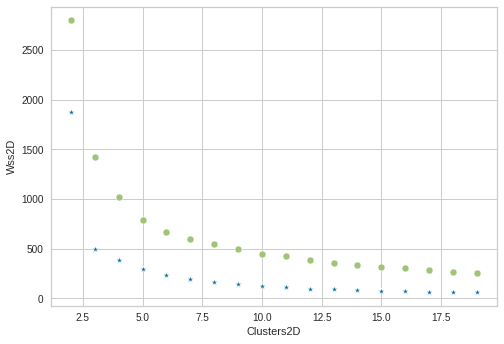

In [ ]:
# Neste exemplo, o cotovelo parece ficar em K=3 (2º ponto no gráfico). Ver mais sobre esse tipo de gráfico:
# https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

import seaborn as sns
sns.scatterplot(x='Clusters2D', y='Wss2D',data=listaWss2D, marker='*')  # Marcador do ponto: asterisco
sns.scatterplot(x='Clusters3D', y='Wss3D',data=listaWss3D)  # Marcador do ponto: círculo
#listaWss

**Método rápido de construir o gráfico de cotovelo (elbow), usando o SKLearn**

Gráfico de colovel (elbow) para os dados 2D:


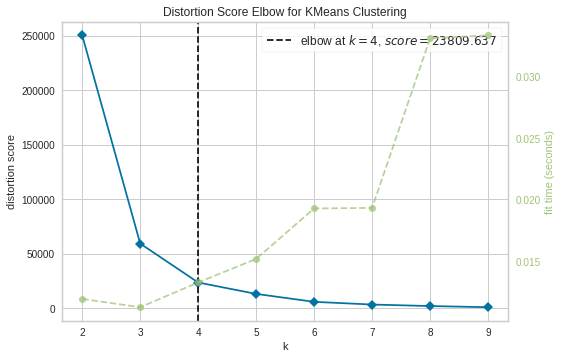

Gráfico de colovel (elbow) para os dados 3D:


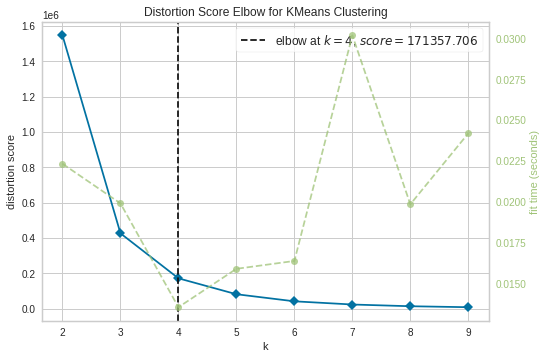

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d04b01950>,
                 estimator=KMeans(n_clusters=9, random_state=1), k=(2, 10))

In [ ]:
# Método rápido de construir o gráfico de cotovelo (elbow), usando o SKLearn
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

# 2D
print ("Gráfico de colovel (elbow) para os dados 2D:")

X=listaWss2D

# Use the quick method and immediately show the figure
kelbow_visualizer(KMeans(random_state=1), X, k=(2,10))

# 3D
print ("Gráfico de colovel (elbow) para os dados 3D:")

X=listaWss3D

# Use the quick method and immediately show the figure
kelbow_visualizer(KMeans(random_state=1), X, k=(2,10))

In [ ]:
display(type(clustering_model_2D))
display(type(pca2_corpus_embeddings))

sklearn.cluster._kmeans.KMeans

numpy.ndarray

**Identificar o cluster com maior valor de Silhouette score**

In [ ]:
#Silhouette score
# O maior valor encontrado foi o de k=2, mas vou usar k=19, pois ficou perto disso
# 2D
print("2D:")
for k in k_rng:
	labels2D=KMeans(n_clusters=k, init='k-means++', random_state=200).fit(pca2_corpus_embeddings).labels_
	print("Silhouette score 2D for k(clusters) = "+str(k)+" is "+
    str(metrics.silhouette_score(pca2_corpus_embeddings, labels2D, metric='euclidean', sample_size=1000, random_state=200)))

# 3D
print("3D:")
for k in k_rng:
	labels3D=KMeans(n_clusters=k, init='k-means++', random_state=200).fit(pca3_corpus_embeddings).labels_
	print("Silhouette score 3D for k(clusters) = "+str(k)+" is "+
    str(metrics.silhouette_score(pca3_corpus_embeddings, labels3D, metric='euclidean', sample_size=1000, random_state=200)))


2D:
Silhouette score 2D for k(clusters) = 2 is 0.6295749
Silhouette score 2D for k(clusters) = 3 is 0.7141824
Silhouette score 2D for k(clusters) = 4 is 0.6563649
Silhouette score 2D for k(clusters) = 5 is 0.49006683
Silhouette score 2D for k(clusters) = 6 is 0.5239463
Silhouette score 2D for k(clusters) = 7 is 0.4528838
Silhouette score 2D for k(clusters) = 8 is 0.4522135
Silhouette score 2D for k(clusters) = 9 is 0.4360331
Silhouette score 2D for k(clusters) = 10 is 0.41954932
Silhouette score 2D for k(clusters) = 11 is 0.4148101
Silhouette score 2D for k(clusters) = 12 is 0.4086816
Silhouette score 2D for k(clusters) = 13 is 0.39583328
Silhouette score 2D for k(clusters) = 14 is 0.37424415
Silhouette score 2D for k(clusters) = 15 is 0.39407593
Silhouette score 2D for k(clusters) = 16 is 0.3890477
Silhouette score 2D for k(clusters) = 17 is 0.38464418
Silhouette score 2D for k(clusters) = 18 is 0.40011495
Silhouette score 2D for k(clusters) = 19 is 0.39065984
3D:
Silhouette score 3D 

**Silhouette score a ser utilizado**

Vamos utilizar os valores de K encontrados no algoritmo Silhouette Score

In [ ]:
# 2D
k_2D=3

num_clusters_2D=k_2D
labels2D=KMeans(n_clusters=k_2D, init='k-means++', random_state=200).fit(pca2_corpus_embeddings).labels_
#clustering_model_2D=KMeans(n_clusters=num_clusters_2D)
#clustering_model_2D.fit(pca2_corpus_embeddings)
#cluster_assignment_2D=clustering_model_2D.labels_
print("Silhouette score 2D for k(clusters) = "+str(k_2D)+" is "+
    str(metrics.silhouette_score(pca2_corpus_embeddings, labels2D, metric='euclidean', sample_size=1000, random_state=200)))

# 3D
k_3D=3

num_clusters_3D=k_3D
labels3D=KMeans(n_clusters=k_3D, init='k-means++', random_state=200).fit(pca3_corpus_embeddings).labels_
#clustering_model_3D=KMeans(n_clusters=num_clusters_3D)
#clustering_model_3D.fit(pca3_corpus_embeddings)
#cluster_assignment_3D=clustering_model_3D.labels_
print("Silhouette score 3D for k(clusters) = "+str(k_3D)+" is "+
    str(metrics.silhouette_score(pca3_corpus_embeddings, labels3D, metric='euclidean', sample_size=1000, random_state=200)))

Silhouette score 2D for k(clusters) = 3 is 0.7141824
Silhouette score 3D for k(clusters) = 3 is 0.5596555


In [ ]:
def contaItensDoCluster(objClusterAssignmt, clusterAContar):
  conta=0
  for i,elem in enumerate(objClusterAssignmt):
    if(elem==clusterAContar):
      conta+=1
  return conta

print("labels2D:")
print(labels2D)
contaTotal=0
for i in range (0,num_clusters_2D):
  conta=contaItensDoCluster(labels2D, i)
  print("Nr de itens no cluster %2d : %2d" % (i, conta))
  contaTotal+=conta
print("Nr de itens totais: %2d" % (contaTotal))
print()
print("labels3D:")
print(labels3D)
contaTotal=0
for i in range (0,num_clusters_3D):
  conta=contaItensDoCluster(labels3D, i)
  print("Nr de itens no cluster %2d : %2d" % (i, conta))
  contaTotal+=conta
print("Nr de itens totais: %2d" % (contaTotal))

labels2D:
[2 0 2 0 2 2 2 2 0 2 0 1 1 2 2 2 1 0 0 2 1 2 2 1 0 0 2 0 0 2 1 2 0 2 2 2 2
 0 2 2 2 1 2 0 0 2 1 0 2 1 0 2 2 2 2 2 2 2 2 2 1 0 0 0 0 2 2 2 2 2 0 2 2 2
 0 1 1 2 0 1 2 2 2 0 2 0 2 0 2 2 2 1 2 1 2 2 2 2 2 2 1 0 2 2 0 2 2 2 2 2 1
 1 1 2 1 1 1 2 2 2 2 2 0 1 1 2 2 1 1 0 2 1 2 0 1 1 1 2 0 0 2 2 2 2 1 2 0 1
 2 1 0 2 2 2 2 2 0 0 2 1 1 2 1 2 1 0 2 2 2 2 1]
Nr de itens no cluster  0 : 38
Nr de itens no cluster  1 : 38
Nr de itens no cluster  2 : 95
Nr de itens totais: 171

labels3D:
[2 0 2 0 2 2 2 2 0 2 0 1 1 2 2 2 1 0 0 2 1 2 2 1 0 0 2 0 0 2 1 2 0 2 2 2 2
 0 2 2 2 1 2 0 0 2 1 0 2 1 0 2 2 2 2 2 2 2 2 2 1 0 0 0 0 2 2 2 2 2 0 2 2 2
 0 1 1 2 0 1 2 2 2 0 2 0 2 0 2 2 2 1 2 1 2 2 2 2 2 2 1 0 2 2 0 2 2 2 2 2 1
 1 1 2 1 1 1 2 2 2 2 2 0 1 1 2 2 1 1 0 2 1 2 0 1 1 1 2 0 0 2 2 2 2 1 2 0 1
 2 1 0 2 2 2 2 2 0 0 2 1 1 2 1 2 1 0 2 2 2 2 1]
Nr de itens no cluster  0 : 38
Nr de itens no cluster  1 : 38
Nr de itens no cluster  2 : 95
Nr de itens totais: 171


In [ ]:
corpus

,Enunciado
0,É competente o Município para fixar o horário de funcionamento de estabelecimento comercial.
1,"A contribuição confederativa de que trata o art. 8º, IV, da Constituição Federal, só é exigível dos filiados ao sindicato respectivo."
2,Compete privativamente à União legislar sobre vencimentos dos membros das polícias civil e militar e do corpo de bombeiros militar do Distrito Fed...
3,O serviço de iluminação pública não pode ser remunerado mediante taxa.
4,É inconstitucional a vinculação do reajuste de vencimentos de servidores estaduais ou municipais a índices federais de correção monetária.
...,...
167,Não compete ao Supremo Tribunal Federal conhecer originariamente de mandado de segurança contra atos de outros tribunais.
168,Não cabe agravo regimental contra decisão do relator que concede ou indefere liminar em mandado de segurança.
169,Ao titular do cargo de procurador de autarquia não se exige a apresentação de instrumento de mandato para representá-la em juízo.
170,"Salvo quando nula a decisão de primeiro grau, o acórdão que provê o recurso contra a rejeição da denúncia vale, desde logo, pelo recebimento dela."


**Apresenta as súmulas e respectivos agrupamentos (clusters)**

Na clusterização de K=3, observamos que os clusters ficaram assim divididos (não necessariamente nesta ordem):
0. Direito Tributário
1. Direito Penal
2. Outros ramos

In [ ]:
display(type(corpus))
df_corpus=pd.DataFrame()
df_corpus['Enunciado']=corpus[0:171]
# 2D
print()
print("Clusters 2D")
df_cluster2D=pd.DataFrame()
df_cluster2D['corpus']=pd.DataFrame(corpus[0:171])
df_cluster2D['corpus2']=pd.DataFrame(corpus2, columns=['corpus'])
df_cluster2D['cluster']=labels2D
df_cluster2D=df_cluster2D.sort_values(by=['cluster'])
df_2D_Cluster0=df_cluster2D.query("cluster==0")
df_2D_Cluster1=df_cluster2D.query("cluster==1")
df_2D_Cluster2=df_cluster2D.query("cluster==2")
display(df_2D_Cluster0)
display(df_2D_Cluster1)
display(df_2D_Cluster2)
# 3D
print()
print("Clusters 3D")
df_cluster3D=pd.DataFrame()
df_cluster3D['corpus']=pd.DataFrame(corpus[0:171])
df_cluster3D['corpus2']=pd.DataFrame(corpus2, columns=['corpus'])
df_cluster3D['cluster']=labels3D
df_cluster3D=df_cluster3D.sort_values(by=['cluster'])
df_3D_Cluster0=df_cluster3D.query("cluster==0")
df_3D_Cluster1=df_cluster3D.query("cluster==1")
df_3D_Cluster2=df_cluster3D.query("cluster==2")
display(df_3D_Cluster0)
display(df_3D_Cluster1)
display(df_3D_Cluster2)

pandas.core.frame.DataFrame


Clusters 2D


,corpus,corpus2,cluster
85,"É constitucional o § 2º do art. 6º da L. 8.024/90, resultante da conversão da MPr 168/90, que fixou o BTN fiscal como índice de correção monetária...",8.024/90 resultante conversão 168/90 fixou fiscal índice correção monetária aplicável depósitos bloqueados plano collor,0
133,A revisão de que trata o art. 58 do ADCT não se aplica aos benefícios previdenciários concedidos após a promulgação da Constituição de 1988.,revisão aplica benefícios tax concedidos após promulgação 1988,0
27,"É constitucional a adoção, no cálculo do valor de taxa, de um ou mais elementos da base de cálculo própria de determinado imposto, desde que não h...",adoção cálculo valor tax elementos base cálculo própria determinado tax integral identidade base outra,0
28,É inconstitucional a exigência de depósito prévio como requisito de admissibilidade de ação judicial na qual se pretenda discutir a exigibilidade ...,exigência depósito prévio requisito admissibilidade ação judicial pretenda discutir exigibilidade crédito tax,0
129,É inconstitucional a lei que estabelece alíquotas progressivas para o imposto de transmissão inter vivos de bens imóveis - ITBI com base no valor ...,estabelece tax progressivas tax transmissão inter vivos bens imóveis tax base valor venal imóvel,0
63,"A contribuição confederativa de que trata o art. 8º, IV, da Constituição, só é exigível dos filiados ao sindicato respectivo.",tax confederativa exigível filiados sindicato,0
122,"É inconstitucional a lei municipal que tenha estabelecido, antes da Emenda Constitucional 29/2000, alíquotas progressivas para o IPTU, salvo se de...",municipal estabelecido antes emenda 29/2000 tax progressivas tax salvo destinada assegurar cumprimento função social propriedade urbana,0
37,"A taxa cobrada exclusivamente em razão dos serviços públicos de coleta, remoção e tratamento ou destinação de lixo ou resíduos provenientes de imó...",tax cobrada exclusivamente razão serviços públicos coleta remoção tratamento destinação lixo resíduos provenientes imóveis,0
43,"Inexiste direito a crédito presumido de IPI relativamente à entrada de insumos isentos, sujeitos à alíquota zero ou não tributáveis, o que não con...",inexiste crédito presumido relativamente entrada insumos isentos sujeitos tax zero tributáveis contraria princípio cumulatividade,0
44,"A imunidade tributária constante do art. 150, VI, d, da CF/88 aplica-se à importação e comercialização, no mercado interno, do livro eletrônico (e...",imunidade tax constante cf/88 aplica-se tax comercialização mercado interno livro eletrônico e-book suportes exclusivamente utilizados fixá-los le...,0


,corpus,corpus2,cluster
124,É nula a decisão que determina o desaforamento de processo da competência do júri sem audiência da defesa.,determina desaforamento processo competência crime audiência defesa,1
136,"Admite-se a progressão de regime de cumprimento da pena ou a aplicação imediata de regime menos severo nela determinada, antes do trânsito em julg...",admite-se progressão regime cumprimento crime aplicação imediata regime menos severo nela determinada antes trânsito julgado sentença condenatória,1
164,Não cabe habeas corpus contra a imposição da pena de exclusão de militar ou de perda de patente ou de função pública.,habeas corpus imposição crime exclusão militar perda patente função pública,1
75,A competência constitucional do Tribunal do Júri prevalece sobre o foro por prerrogativa de função estabelecido exclusivamente pela Constituição e...,competência crime prevalece foro prerrogativa função estabelecido exclusivamente estadual,1
76,Compete originariamente ao Supremo Tribunal Federal o julgamento de habeas corpus contra decisão de turma recursal de juizados especiais criminais.,compete originariamente julgamento habeas corpus turma recursal juizados especiais crime,1
162,"Constitui nulidade a falta de intimação do denunciado para oferecer contra-razões ao recurso interposto da rejeição da denúncia, não a suprindo a ...",nulidade falta intimação denunciado oferecer contra-razões interposto rejeição crime suprindo nomeação defensor dativo,1
79,"Não se admite a suspensão condicional do processo por crime continuado, se a soma da pena mínima da infração mais grave com o aumento mínimo de um...",admite suspensão condicional processo crime continuado soma crime mínima infração grave aumento mínimo sexto superior,1
160,O efeito devolutivo da apelação contra decisões do Júri é adstrito aos fundamentos da sua interposição.,efeito devolutivo apelação decisões crime adstrito fundamentos interposição,1
159,A proibição de liberdade provisória nos processos por crimes hediondos não veda o relaxamento da prisão processual por excesso de prazo.,proibição crime provisória processos crime hediondos veda relaxamento crime processual excesso,1
91,"Não cabe habeas corpus contra decisão condenatória a pena de multa, ou relativo a processo em curso por infração penal a que a pena pecuniária sej...",habeas corpus condenatória crime multa relativo processo curso infração crime crime pecuniária única cominada,1


,corpus,corpus2,cluster
140,Controvérsia sobre matéria de direito não impede concessão de mandado de segurança.,controvérsia matéria impede concessão mandado segurança,2
19,Os honorários advocatícios incluídos na condenação ou destacados do montante principal devido ao credor consubstanciam verba de natureza alimentar...,honorários advocatícios incluídos condenação destacados montante principal devido credor consubstanciam verba natureza alimentar cuja satisfação o...,2
137,"A renúncia do réu ao direito de apelação, manifestada sem a assistência do defensor, não impede o conhecimento da apelação por este interposta.",renúncia apelação manifestada assistência defensor impede conhecimento apelação interposta,2
21,"Aplicam-se ao servidor público, no que couber, as regras do regime geral da previdência social sobre aposentadoria especial de que trata o artigo ...",aplicam-se servidor público couber regras regime geral previdência social aposentadoria especial edição complementar específica,2
22,"A Gratificação de Desempenho de Atividade de Seguridade Social e do Trabalho - GDASST, instituída pela Lei 10.483/2002, deve ser estendida aos ina...",gratificação desempenho atividade seguridade social trabalho gdasst instituída 10.483/2002 deve estendida inativos valor correspondente sessenta p...,2
132,"Não contraria a Constituição o art. 15, § 1º, do Dl. 3.365/41 (Lei da Desapropriação por utilidade pública).",contraria 3.365/41 desapropriação utilidade pública,2
141,"Não gera por si só a competência originária do Supremo Tribunal Federal para conhecer do mandado de segurança com base no art. 102, I, n, da Const...",gera competência originária conhecer mandado segurança base dirigir-se pedido deliberação administrativa origem participado maioria totalidade mem...,2
29,"Compete à Justiça estadual julgar causas entre consumidor e concessionária de serviço público de telefonia, quando a ANATEL não seja litisconsorte...",compete estadual julgar causas consumidor concessionária serviço público telefonia anatel litisconsorte passiva necessária assistente opoente,2
130,Os §§ 1º e 3º do art. 9º do Dl. 406/68 foram recebidos pela Constituição.,406/68 recebidos,2
31,A Justiça do Trabalho é competente para processar e julgar as ações de indenização por danos morais e patrimoniais decorrentes de acidente de trab...,trabalho competente processar julgar ações indenização danos morais patrimoniais decorrentes acidente trabalho propostas empregado empregador incl...,2



Clusters 3D


,corpus,corpus2,cluster
85,"É constitucional o § 2º do art. 6º da L. 8.024/90, resultante da conversão da MPr 168/90, que fixou o BTN fiscal como índice de correção monetária...",8.024/90 resultante conversão 168/90 fixou fiscal índice correção monetária aplicável depósitos bloqueados plano collor,0
133,A revisão de que trata o art. 58 do ADCT não se aplica aos benefícios previdenciários concedidos após a promulgação da Constituição de 1988.,revisão aplica benefícios tax concedidos após promulgação 1988,0
27,"É constitucional a adoção, no cálculo do valor de taxa, de um ou mais elementos da base de cálculo própria de determinado imposto, desde que não h...",adoção cálculo valor tax elementos base cálculo própria determinado tax integral identidade base outra,0
28,É inconstitucional a exigência de depósito prévio como requisito de admissibilidade de ação judicial na qual se pretenda discutir a exigibilidade ...,exigência depósito prévio requisito admissibilidade ação judicial pretenda discutir exigibilidade crédito tax,0
129,É inconstitucional a lei que estabelece alíquotas progressivas para o imposto de transmissão inter vivos de bens imóveis - ITBI com base no valor ...,estabelece tax progressivas tax transmissão inter vivos bens imóveis tax base valor venal imóvel,0
63,"A contribuição confederativa de que trata o art. 8º, IV, da Constituição, só é exigível dos filiados ao sindicato respectivo.",tax confederativa exigível filiados sindicato,0
122,"É inconstitucional a lei municipal que tenha estabelecido, antes da Emenda Constitucional 29/2000, alíquotas progressivas para o IPTU, salvo se de...",municipal estabelecido antes emenda 29/2000 tax progressivas tax salvo destinada assegurar cumprimento função social propriedade urbana,0
37,"A taxa cobrada exclusivamente em razão dos serviços públicos de coleta, remoção e tratamento ou destinação de lixo ou resíduos provenientes de imó...",tax cobrada exclusivamente razão serviços públicos coleta remoção tratamento destinação lixo resíduos provenientes imóveis,0
43,"Inexiste direito a crédito presumido de IPI relativamente à entrada de insumos isentos, sujeitos à alíquota zero ou não tributáveis, o que não con...",inexiste crédito presumido relativamente entrada insumos isentos sujeitos tax zero tributáveis contraria princípio cumulatividade,0
44,"A imunidade tributária constante do art. 150, VI, d, da CF/88 aplica-se à importação e comercialização, no mercado interno, do livro eletrônico (e...",imunidade tax constante cf/88 aplica-se tax comercialização mercado interno livro eletrônico e-book suportes exclusivamente utilizados fixá-los le...,0


,corpus,corpus2,cluster
124,É nula a decisão que determina o desaforamento de processo da competência do júri sem audiência da defesa.,determina desaforamento processo competência crime audiência defesa,1
136,"Admite-se a progressão de regime de cumprimento da pena ou a aplicação imediata de regime menos severo nela determinada, antes do trânsito em julg...",admite-se progressão regime cumprimento crime aplicação imediata regime menos severo nela determinada antes trânsito julgado sentença condenatória,1
164,Não cabe habeas corpus contra a imposição da pena de exclusão de militar ou de perda de patente ou de função pública.,habeas corpus imposição crime exclusão militar perda patente função pública,1
75,A competência constitucional do Tribunal do Júri prevalece sobre o foro por prerrogativa de função estabelecido exclusivamente pela Constituição e...,competência crime prevalece foro prerrogativa função estabelecido exclusivamente estadual,1
76,Compete originariamente ao Supremo Tribunal Federal o julgamento de habeas corpus contra decisão de turma recursal de juizados especiais criminais.,compete originariamente julgamento habeas corpus turma recursal juizados especiais crime,1
162,"Constitui nulidade a falta de intimação do denunciado para oferecer contra-razões ao recurso interposto da rejeição da denúncia, não a suprindo a ...",nulidade falta intimação denunciado oferecer contra-razões interposto rejeição crime suprindo nomeação defensor dativo,1
79,"Não se admite a suspensão condicional do processo por crime continuado, se a soma da pena mínima da infração mais grave com o aumento mínimo de um...",admite suspensão condicional processo crime continuado soma crime mínima infração grave aumento mínimo sexto superior,1
160,O efeito devolutivo da apelação contra decisões do Júri é adstrito aos fundamentos da sua interposição.,efeito devolutivo apelação decisões crime adstrito fundamentos interposição,1
159,A proibição de liberdade provisória nos processos por crimes hediondos não veda o relaxamento da prisão processual por excesso de prazo.,proibição crime provisória processos crime hediondos veda relaxamento crime processual excesso,1
91,"Não cabe habeas corpus contra decisão condenatória a pena de multa, ou relativo a processo em curso por infração penal a que a pena pecuniária sej...",habeas corpus condenatória crime multa relativo processo curso infração crime crime pecuniária única cominada,1


,corpus,corpus2,cluster
140,Controvérsia sobre matéria de direito não impede concessão de mandado de segurança.,controvérsia matéria impede concessão mandado segurança,2
19,Os honorários advocatícios incluídos na condenação ou destacados do montante principal devido ao credor consubstanciam verba de natureza alimentar...,honorários advocatícios incluídos condenação destacados montante principal devido credor consubstanciam verba natureza alimentar cuja satisfação o...,2
137,"A renúncia do réu ao direito de apelação, manifestada sem a assistência do defensor, não impede o conhecimento da apelação por este interposta.",renúncia apelação manifestada assistência defensor impede conhecimento apelação interposta,2
21,"Aplicam-se ao servidor público, no que couber, as regras do regime geral da previdência social sobre aposentadoria especial de que trata o artigo ...",aplicam-se servidor público couber regras regime geral previdência social aposentadoria especial edição complementar específica,2
22,"A Gratificação de Desempenho de Atividade de Seguridade Social e do Trabalho - GDASST, instituída pela Lei 10.483/2002, deve ser estendida aos ina...",gratificação desempenho atividade seguridade social trabalho gdasst instituída 10.483/2002 deve estendida inativos valor correspondente sessenta p...,2
132,"Não contraria a Constituição o art. 15, § 1º, do Dl. 3.365/41 (Lei da Desapropriação por utilidade pública).",contraria 3.365/41 desapropriação utilidade pública,2
141,"Não gera por si só a competência originária do Supremo Tribunal Federal para conhecer do mandado de segurança com base no art. 102, I, n, da Const...",gera competência originária conhecer mandado segurança base dirigir-se pedido deliberação administrativa origem participado maioria totalidade mem...,2
29,"Compete à Justiça estadual julgar causas entre consumidor e concessionária de serviço público de telefonia, quando a ANATEL não seja litisconsorte...",compete estadual julgar causas consumidor concessionária serviço público telefonia anatel litisconsorte passiva necessária assistente opoente,2
130,Os §§ 1º e 3º do art. 9º do Dl. 406/68 foram recebidos pela Constituição.,406/68 recebidos,2
31,A Justiça do Trabalho é competente para processar e julgar as ações de indenização por danos morais e patrimoniais decorrentes de acidente de trab...,trabalho competente processar julgar ações indenização danos morais patrimoniais decorrentes acidente trabalho propostas empregado empregador incl...,2


**Plotando os pontos representativos das sumulas, por cluster**

Clique no gráfico para mudá-lo de posição.


In [ ]:
import plotly.express as px
display(labels2D.shape)
tamX=labels2D.shape  # o tamanho de labels3D é o mesmo
lstY=list(range(tamX[0]))

# No gráfico abaixo, as cores (colors) coincidem com os agrupamentos (clusters) e os símbolos (symbols) correspondem com cada texto de súmula do STF
print("Gráfico 3D")
fig = px.scatter_3d(pca3_corpus_embeddings, x=0, y=1, z=2, color=labels3D,
                    color_continuous_scale=px.colors.sequential.Rainbow, size_max=20,
                    text=lstY)
fig.show()

print("Gráfico 2D")
fig = px.scatter(pca2_corpus_embeddings, x=0, y=1, color=labels2D,
                    color_continuous_scale=px.colors.sequential.Rainbow, size_max=20,
                    text=lstY)
fig.show()

(171,)

Gráfico 3D


Gráfico 2D


In [ ]:
# Verifique que estes pontos estão bem próximos uns dos outros, nos gráficos acima, o que faz sentido,
# pois todos tratam de Direito Penal ou apresentam alguma forma do radical da palavra crime
# (crime, criminal etc):
# A clusterização ideal os colocaria em um único cluster
#print(corpus)
print(df_corpus['Enunciado'][11])
print(df_corpus['Enunciado'][20])
print(df_corpus['Enunciado'][32])
print(df_corpus['Enunciado'][41])
print(df_corpus['Enunciado'][49])
print(df_corpus['Enunciado'][60])
print(df_corpus['Enunciado'][79])
print(df_corpus['Enunciado'][111])
print(df_corpus['Enunciado'][114])
print(df_corpus['Enunciado'][115])
print(df_corpus['Enunciado'][123])
print(df_corpus['Enunciado'][131])
print(df_corpus['Enunciado'][147])
print(df_corpus['Enunciado'][159])


A definição dos crimes de responsabilidade e o estabelecimento das respectivas normas de processo e julgamento são da competência legislativa privativa da União.
Compete à Justiça Federal comum processar e julgar civil denunciado pelos crimes de falsificação e de uso de documento falso quando se tratar de falsificação da Caderneta de Inscrição e Registro (CIR) ou de Carteira de Habilitação de Amador (CHA), ainda que expedidas pela Marinha do Brasil.
Não se tipifica crime material contra a ordem tributária, previsto no art. 1º, incisos I a IV, da Lei nº 8.137/90, antes do lançamento definitivo do tributo.
Para efeito de progressão de regime no cumprimento de pena por crime hediondo, ou equiparado, o juízo da execução observará a inconstitucionalidade do art. 2º da Lei n. 8.072, de 25 de julho de 1990, sem prejuízo de avaliar se o condenado preenche, ou não, os requisitos objetivos e subjetivos do benefício, podendo determinar, para tal fim, de modo fundamentado, a realização de exame cr

**Resultados**

*Results*


In [ ]:
#Resultados
#Results
# Farei somente para 2D
clustered_sentences=[[] for i in range(num_clusters_2D)]
for sentence_id, cluster_id in enumerate(labels2D):
	clustered_sentences[cluster_id].append(df_corpus['Enunciado'][sentence_id])

print(len(clustered_sentences))

for i, cluster in enumerate(clustered_sentences):
  print("Cluster ", i+1)
  for j, item in enumerate(cluster):
    if (j>4):
      break
    print(item)
    print("")

3
Cluster  1
A contribuição confederativa de que trata o art. 8º, IV, da Constituição Federal, só é exigível dos filiados ao sindicato respectivo.

O serviço de iluminação pública não pode ser remunerado mediante taxa.

Ainda quando alugado a terceiros, permanece imune ao IPTU o imóvel pertencente a qualquer das entidades referidas pelo art. 150, VI, c, da Constituição Federal, desde que o valor dos aluguéis seja aplicado nas atividades para as quais tais entidades foram constituídas.

Na entrada de mercadoria importada do exterior, é legítima a cobrança do ICMS por ocasião do desembaraço aduaneiro.

Norma legal que altera o prazo de recolhimento de obrigação tributária não se sujeita ao princípio da anterioridade.

Cluster  2
A definição dos crimes de responsabilidade e o estabelecimento das respectivas normas de processo e julgamento são da competência legislativa privativa da União.

A competência constitucional do Tribunal do Júri prevalece sobre o foro por prerrogativa de função e

**Apresentando as nuvens de palavras**

*Word clouds*

('tax', 53)('valor', 5)('cobrança', 5)('entidades', 5)('serviço', 5)
('crime', 62)('processo', 15)('se', 7)('competência', 6)('execução', 6)
('público', 14)('se', 12)('mandado segurança', 10)('cargo', 9)('servidores', 8)


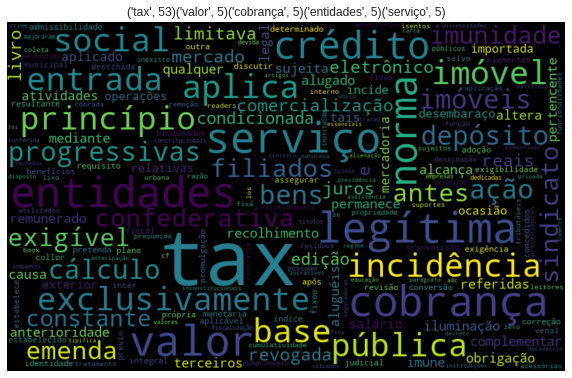

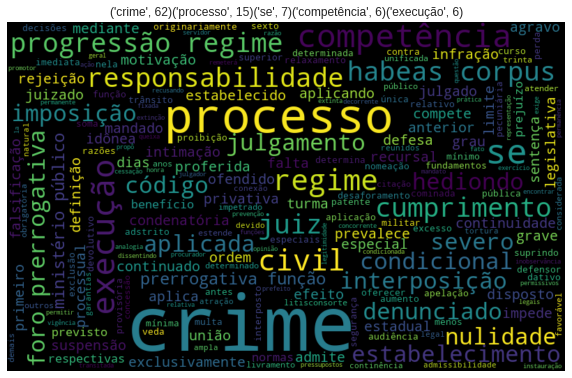

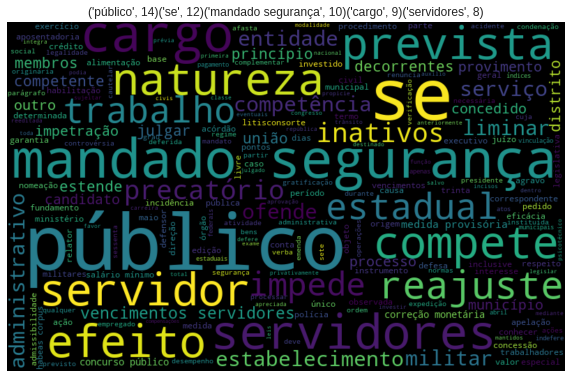

In [ ]:
#Nuvem de palavras
#Word Cloud

def criaDicFreqs(wordcloud, text):
  # create a dictionary of word frequencies
  text_dictionary = wordcloud.process_text(text)
  # sort the dictionary
  word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

  #use words_ to print relative word frequencies
  rel_freq=wordcloud.words_

  #return results
  strRetorno=list(word_freq.items())[:5]
  strRetorno=''.join(str(e) for e in strRetorno)
  return(strRetorno)

def word_cloud(pred_df, label):
  wc=' '.join([text for text in pred_df['corpus2'][pred_df['cluster'] == label]])
  #tokensfd = nltk.tokenize.word_tokenize(pred_df['corpus2'][label])
  #fdist = nltk.FreqDist(tokensfd)
  #print(fdist.most_common())
  #create the wordcloud object
  wordcloud=WordCloud(width=800, height=500,
  random_state=21,
  max_font_size=110).generate(wc)
  listaFreqWords=criaDicFreqs(wordcloud, wc)
  print(listaFreqWords)
  fig=plt.figure(figsize=(10,7))
  plt.imshow(wordcloud, interpolation="bilinear")
  # displaying the title
  plt.title(listaFreqWords)
  plt.axis('off')

for i in range(0,num_clusters_2D):
  word_cloud(df_cluster2D,i)
